 <font size="15"> Imports</font> 

In [1]:
pip install wordcloud

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import re
import sys

np.set_printoptions(threshold=sys.maxsize)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

from scipy.sparse import coo_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 <font size="15">Data Exploration</font> 

In [3]:
analytics_country_data_pdf = pd.read_csv("analytics_country_data.csv")
print(analytics_country_data_pdf.head())

          country        users    new_users       sessions bounce_rate  \
0   United States  434,944,680  427,058,422  1,202,850,944      59.86%   
1          Canada   58,957,484   56,514,054    160,809,556      58.49%   
2  United Kingdom   46,435,791   44,456,259    103,884,722      61.56%   
3       Australia   23,587,951   22,614,120     58,504,210      61.07%   
4         Germany    7,542,762    7,057,617     16,473,675      55.65%   

   pages_per_session session_duration  
0               1.32          0:02:35  
1               1.31          0:02:53  
2               1.35          0:02:25  
3               1.39          0:02:51  
4               1.38          0:03:13  


In [4]:
daily_users = pd.read_csv('analytics_daily_users.csv')
print(daily_users.head())

         date    users new_users  sessions_per_user sessions session_duration  \
0  2013-01-01   67,283    17,706               1.05   68,825          0:01:46   
1  2013-01-02  123,942    53,118               1.03      NaN          0:01:25   
2  2013-01-03  194,766    88,530               1.13      NaN          0:01:05   
3  2013-01-04  237,261   123,942               1.09      NaN          0:02:09   
4  2013-01-05  134,566    60,200               1.13      NaN          0:01:35   

  bounce_rate pageviews  pages_per_session  
0      80.00%    82,590               1.15  
1      72.22%       NaN               1.44  
2      77.42%       NaN               1.31  
3      87.67%       NaN               1.15  
4      76.74%       NaN               1.26  


In [5]:
packages = pd.read_csv('packages.csv')
print(packages.head())

   created_at   test_week                   test_id  \
0  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
1  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
2  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
3  2014-11-20  2014-11-17  546d902c26714c6c44000039   
4  2014-11-20  2014-11-17  546d902c26714c6c44000039   

                                            headline  \
0  They're Being Called 'Walmart's Worst Nightmar...   
1  They're Being Called 'Walmart's Worst Nightmar...   
2  They're Being Called 'Walmart's Worst Nightmar...   
3        This Is What Sexism Against Men Sounds Like   
4        This Is What Sexism Against Men Sounds Like   

                   image_id                           excerpt  \
0  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
1  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
2  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
3  546bc55335992b86c8000043  Things that matter. Pass 'em on.   
4  546d

In [6]:
func = lambda i: i[:-1]
daily_users['bounce_rate'] = daily_users['bounce_rate'].apply(func)
bounce_rate = daily_users
bounce_rate = bounce_rate.astype({'bounce_rate': float})

In [7]:
ratio = lambda row: float(row['clicks']) / float(row['impressions'])
packages['new_column'] = packages.apply(ratio, axis=1)
print(packages['new_column'])

0         0.049148
1         0.040224
2         0.035576
3         0.025525
4         0.034227
            ...   
150812    0.005294
150813    0.016672
150814    0.031642
150815    0.028941
150816    0.039179
Name: new_column, Length: 150817, dtype: float64


In [8]:
max_ratio = packages.groupby(['test_id'], as_index=False, sort=False)['new_column'].max()
added_ratio = pd.DataFrame(max_ratio)
added_ratio = added_ratio.rename(columns={'new_column' : 'max_ratio'})
packages = packages.merge(added_ratio, how='inner', on='test_id')
ratio_func = lambda row: row['new_column'] == row['max_ratio']
packages['winner_ratio'] = packages.apply(ratio_func, axis=1)
print(packages.head())

   created_at   test_week                   test_id  \
0  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
1  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
2  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
3  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
4  2014-11-20  2014-11-17  546d902c26714c6c44000039   

                                            headline  \
0  They're Being Called 'Walmart's Worst Nightmar...   
1  They're Being Called 'Walmart's Worst Nightmar...   
2  They're Being Called 'Walmart's Worst Nightmar...   
3  They're Being Called 'Walmart's Worst Nightmar...   
4        This Is What Sexism Against Men Sounds Like   

                   image_id                           excerpt  \
0  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
1  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
2  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
3  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
4  546b

### https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

 <font size="15"> Data Cleaning and NLP</font> 

In [9]:
distinct = list(set(list(packages['headline']))) 
dataset = pd.DataFrame()
dataset['headline'] = pd.Series(distinct)

dataset['word_count'] = dataset['headline'].apply(lambda x: len(str(x).split(" ")))
freq = pd.Series(' '.join(str(dataset['headline'])).split()).value_counts()
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "large", "also", "one", "two", "new", "previously", "shown", "like", "get", "could", "would"]
stop_words = stop_words.union(new_words)

length = dataset.shape[0]
corpus = []
for i in range(length):
    #Remove punctuations

    text = re.sub('[^a-zA-Z]', ' ', str(dataset['headline'][i]))
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    if (text!='nan'):
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        
        corpus.append(text)
    

corpus[2]

'surprising creepy place men still act woman'

In [10]:
print(distinct[:6])

['A Woman With A Baby Was Being Harassed. Find Out The 3 Unlikely Words That Stopped It.', "This Might Be Jon Stewart's Best Rant Ever. Because Racism.", 'The Surprising And Creepy Place Where Men Still Act Like They Own Women', 'Roller Coastering On The Stock Market Is Fun, Except For The Part Where 99.99% Of Us Get Thrown Off', 'What Do 19th Century Pornographers Have To Do With Your Favorite High Heels?', nan]


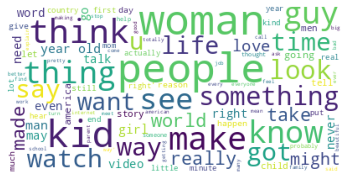

In [11]:
wc = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wc)
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

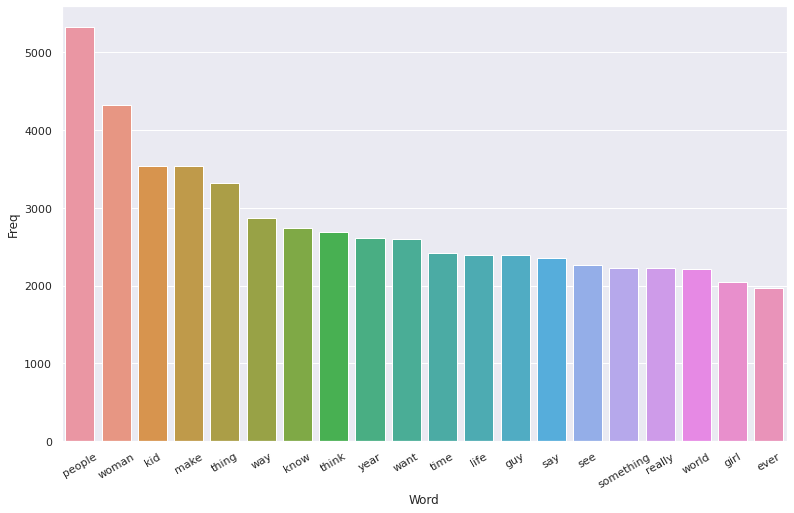

In [12]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

top_20_n1 = top_words


           Bi-gram  Freq
0         year old   972
1      little girl   355
2         year ago   316
3   climate change   283
4     minimum wage   260
5        next time   226
6        every day   225
7     gay marriage   220
8      john oliver   215
9        want know   209
10       ever seen   198
11     good reason   192
12      ever heard   174
13    white people   168
14        fox news   163
15        anti gay   159
16     jon stewart   152
17      gay people   152
18       need know   149
19     high school   147


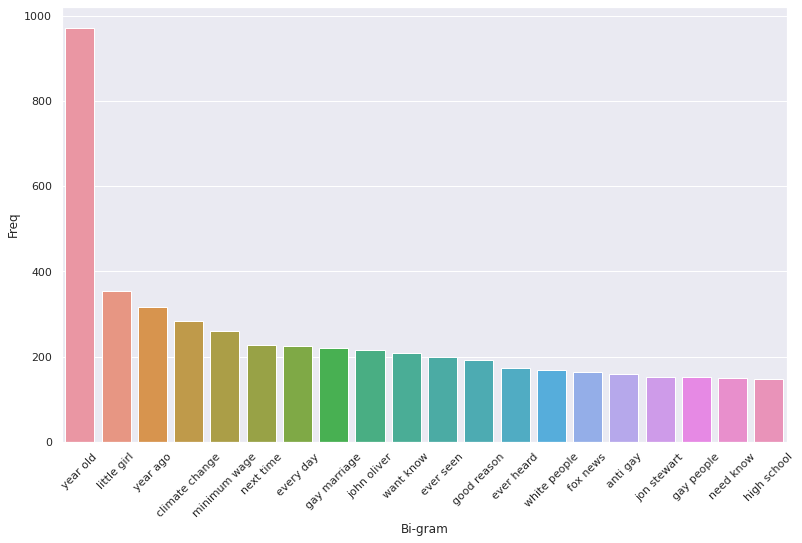

In [13]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

top_20_n2 = top_words

                    Tri-gram  Freq
0              year old girl   141
1        neil degrasse tyson    93
2       raising minimum wage    61
3       ice bucket challenge    55
4               year old kid    52
5         really good reason    52
6          next time someone    42
7       everything need know    41
8         martin luther king    37
9         fact checked thing    33
10     supreme court justice    32
11        want date daughter    29
12          fast food worker    29
13             wait till see    28
14              year old boy    27
15            john oliver go    27
16            watch year old    27
17       dirty little secret    26
18             boy want date    25
19  argument raising minimum    25


[Text(0, 0, 'year old girl'),
 Text(1, 0, 'neil degrasse tyson'),
 Text(2, 0, 'raising minimum wage'),
 Text(3, 0, 'ice bucket challenge'),
 Text(4, 0, 'year old kid'),
 Text(5, 0, 'really good reason'),
 Text(6, 0, 'next time someone'),
 Text(7, 0, 'everything need know'),
 Text(8, 0, 'martin luther king'),
 Text(9, 0, 'fact checked thing'),
 Text(10, 0, 'supreme court justice'),
 Text(11, 0, 'want date daughter'),
 Text(12, 0, 'fast food worker'),
 Text(13, 0, 'wait till see'),
 Text(14, 0, 'year old boy'),
 Text(15, 0, 'john oliver go'),
 Text(16, 0, 'watch year old'),
 Text(17, 0, 'dirty little secret'),
 Text(18, 0, 'boy want date'),
 Text(19, 0, 'argument raising minimum')]

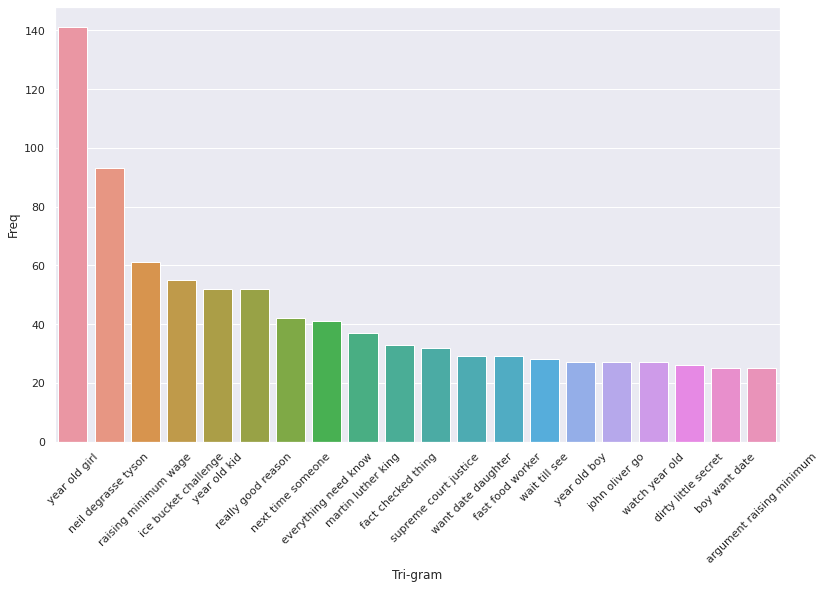

In [14]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [15]:
packages_winners = packages[packages['winner'] == True]
packages_winners.dropna(subset=['share_text'], inplace = True)
print(packages_winners.head())

     created_at   test_week                   test_id  \
0    2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
24   2014-11-20  2014-11-17  546dfa4226714c0538000064   
85   2014-11-21  2014-11-17  546f486992f391bd48000025   
86   2014-11-21  2014-11-17  546f4e0387942a3efd000029   
101  2014-11-21  2014-11-17  546f889587942aedcb000048   

                                              headline  \
0    They're Being Called 'Walmart's Worst Nightmar...   
24   A Bunch Of Celebrities Recorded A Song To Rais...   
85   People Ask This Lesbian Questions And Her Rais...   
86   Kim Jong Un Would Really Hate For You To Watch...   
101  I Thought They Were Just Sharing Their Passion...   

                     image_id                           excerpt  \
0    546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
24   546df33b84ad3834f000004c  Things that matter. Pass 'em on.   
85   546d1b4bfd3617f091000041  Things that matter. Pass 'em on.   
86   546df39a84ad380b59000037  Things th

In [16]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 

    # fetch document for which keywords needs to be extracted
doc=corpus[0]
 
    #generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:

    print(k,keywords[k])


Abstract:
woman baby harassed find unlikely word stopped

Keywords:
harassed 0.483
unlikely 0.48
stopped 0.407
baby 0.352
find 0.341
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
packages_winners['word_count'] = packages_winners['share_text'].apply(lambda x: len(str(x).split(" ")))
packages_winners_wordCount = pd.DataFrame({"share_text": packages_winners['share_text'], "word_count": packages_winners['word_count']})
print(packages_winners_wordCount)
print(packages_winners_wordCount[packages_winners_wordCount['word_count'] == 68])

                                               share_text  word_count
0       Anyone who's ever felt guilty about shopping a...          15
24      Powerful quotes from the musician who turned d...          13
85      I love how it's simultaneously hilarious and r...           9
86      I thought I knew what life was like in North K...          18
101            They didn't think it could happen to them.           8
...                                                   ...         ...
150670  Nothing could possibly prepare a parent for th...           9
150730  Bravo to Laverne Cox for speaking up and speak...          11
150764  This would have gone way over my head in 2nd g...          19
150771  That green screen before the movie preview wil...          13
150788  How does this guy still have a job?! Sorry, I ...          15

[2081 rows x 2 columns]
                                              share_text  word_count
27317  Today is Holocaust Remembrance Day and the 70t...          

In [18]:
packages_winners_wordCount.describe()

word_count
count  2081.000000
mean     12.227775
std       6.113590
min       1.000000
25%       8.000000
50%      12.000000
75%      16.000000
max      68.000000

In [19]:
common_words_freq = pd.Series(''.join(packages_winners_wordCount['share_text']).split()).value_counts()[:20]
print(common_words_freq)

the      705
a        616
to       596
of       380
is       336
this     314
and      280
I        272
you      253
in       222
it       212
that     195
about    177
what     166
but      164
for      159
was      138
are      132
on       131
be       128
dtype: int64


In [20]:
uncommon_words_freq = pd.Series(''.join(packages_winners_wordCount['share_text']).split()).value_counts()[-20:]
print(uncommon_words_freq)

addiction.How         1
insurance             1
Alabama.              1
cleared.A             1
concerned.Remember    1
tearing               1
there.What            1
walking."Millions     1
it...it's             1
hopefully             1
look.Wow.             1
science.They've       1
compliment            1
Buffy                 1
Time                  1
it.Just               1
members               1
skeptical             1
AV                    1
mind.Beautiful.       1
dtype: int64


In [21]:
stop_words = set(stopwords.words("english"))
new_words = ["using", "show", "large", "also", "one", "two", "new", "previously", "shown", "like", "get", "could", "would"]
stop_words = stop_words.union(new_words)

In [22]:
distinct = list(set(list(packages['share_text']))) 
dataset = pd.DataFrame()
dataset['share_text'] = pd.Series(distinct)

dataset['word_count'] = dataset['share_text'].apply(lambda x: len(str(x).split(" ")))
freq = pd.Series(' '.join(str(dataset['share_text'])).split()).value_counts()
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "large", "also", "one", "two", "new", "previously", "shown", "like", "get", "could", "would"]
stop_words = stop_words.union(new_words)

length = dataset.shape[0]
corpus = []
for i in range(length):
    #Remove punctuations

    text = re.sub('[^a-zA-Z]', ' ', str(dataset['share_text'][i]))
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    if (text!='nan'):
        ##Convert to list from string
        text = text.split()
        
        ##Stemming
        ps=PorterStemmer()
        #Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        
        corpus.append(text)
    

corpus[2]

'wow mean wow'

In [23]:
print(dataset.head())

                                          share_text  word_count
0                                                NaN           1
1         Spoiler alert: Nothing! They can't do it.            8
2  Forbes called this super-rich guy ‘near insane...          10
3                                  Wow. I mean, WOW.           4
4  "No one should be made to feel bad because of ...          15


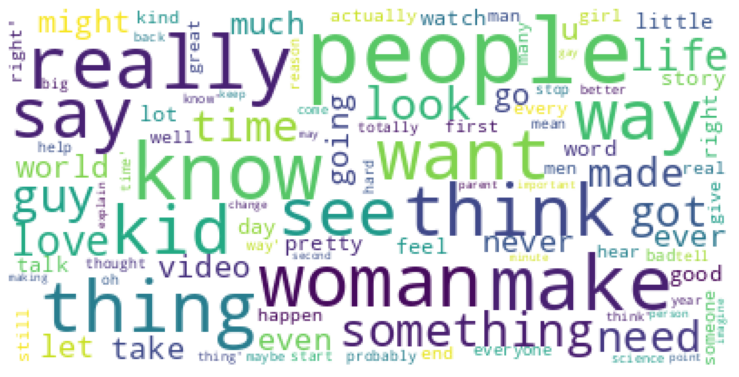

In [24]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word2.png", dpi=900)

In [25]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)
list(cv.vocabulary_.keys())[:10]

['spoiler',
 'alert',
 'nothing',
 'spoiler alert',
 'spoiler alert nothing',
 'called',
 'super',
 'rich',
 'guy',
 'near']

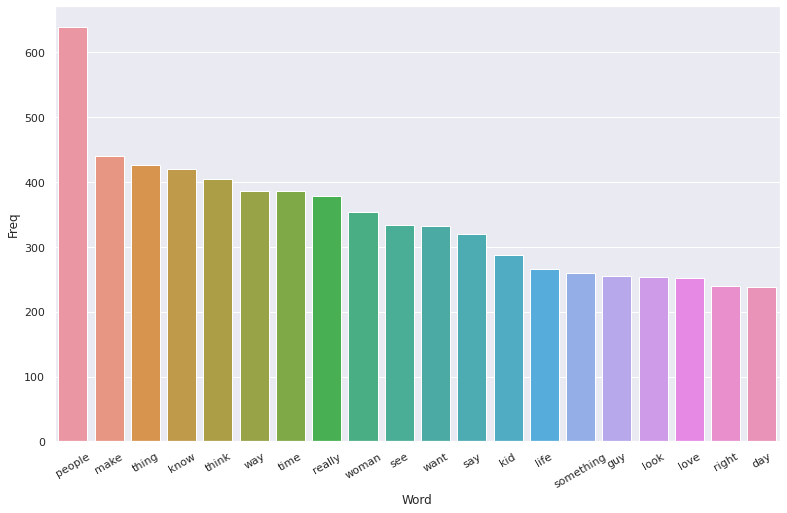

In [26]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

top_20_n1_txt = top_words

           Bi-gram  Freq
0         year old    67
1      many people    39
2        every day    38
3         year ago    33
4          yes yes    32
5      little girl    32
6        next time    29
7   climate change    28
8         big deal    27
9        make want    23
10      ever heard    23
11     never heard    23
12       make sure    22
13     john oliver    22
14       make feel    22
15      video game    21
16    people think    20
17       real life    19
18       ever seen    19
19      lot people    19


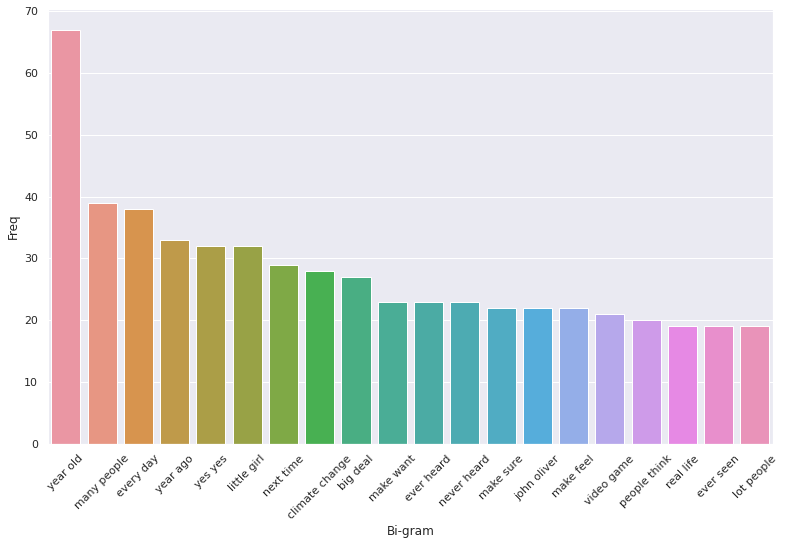

In [27]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

top_20_n2_txt = top2_words

                     Tri-gram  Freq
0                 yes yes yes    22
1   david phillips researcher    11
2   phillips researcher study    11
3    researcher study suicide    11
4          study suicide said    11
5          suicide said think    11
6          said think suicide    11
7         think suicide story    11
8          suicide story kind    11
9       story kind commercial    11
10       kind commercial make    11
11    commercial make product    11
12    make product attractive    11
13  product attractive people    11
14     attractive people want    11
15          next time someone    10
16        neil degrasse tyson    10
17       ice bucket challenge     9
18            gov jerry brown     8
19             wait see movie     7


[Text(0, 0, 'yes yes yes'),
 Text(1, 0, 'david phillips researcher'),
 Text(2, 0, 'phillips researcher study'),
 Text(3, 0, 'researcher study suicide'),
 Text(4, 0, 'study suicide said'),
 Text(5, 0, 'suicide said think'),
 Text(6, 0, 'said think suicide'),
 Text(7, 0, 'think suicide story'),
 Text(8, 0, 'suicide story kind'),
 Text(9, 0, 'story kind commercial'),
 Text(10, 0, 'kind commercial make'),
 Text(11, 0, 'commercial make product'),
 Text(12, 0, 'make product attractive'),
 Text(13, 0, 'product attractive people'),
 Text(14, 0, 'attractive people want'),
 Text(15, 0, 'next time someone'),
 Text(16, 0, 'neil degrasse tyson'),
 Text(17, 0, 'ice bucket challenge'),
 Text(18, 0, 'gov jerry brown'),
 Text(19, 0, 'wait see movie')]

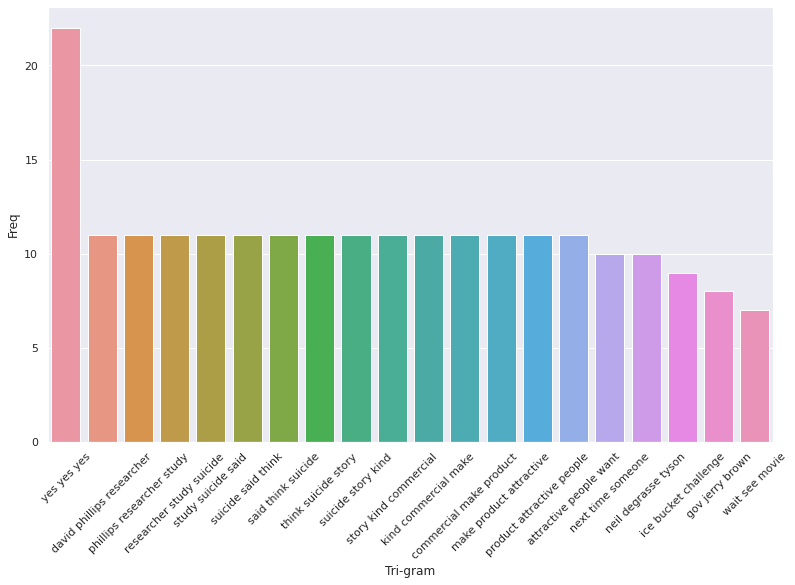

In [28]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [29]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[532]
 
#generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items, 10000)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
ever wondered grow gay read

Keywords:
ever wondered 0.475
grow 0.449
wondered 0.439
read 0.416
gay 0.35
ever 0.29


 <font size="15"> SVM/Logistic Regression, Random Forest</font> 

In [31]:
descriptors = packages
descriptors['char_len_headline'] = descriptors['headline'].apply(lambda x: len(str(x)))
descriptors['char_len_text'] = descriptors['share_text'].apply(lambda x: len(str(x)))

len_func = lambda x: str(x).count(' ') + 1
descriptors['word_num_headline'] = descriptors['headline'].apply(len_func)
descriptors['word_num_text'] = descriptors['share_text'].apply(len_func)

avg_len_func = lambda x: float(x['char_len_headline'])/float(x['word_num_headline'])
descriptors['avg_num_headline'] = descriptors.apply(avg_len_func, axis = 1)
avg_len_func = lambda x: float(x['char_len_text'])/float(x['word_num_text'])
descriptors['avg_num_text'] = descriptors.apply(avg_len_func, axis=1)

num_caps = lambda message: sum(1 for c in str(message) if c.isupper())
descriptors['num_caps_headline'] = descriptors['headline'].apply(num_caps)
descriptors['num_caps_text'] = descriptors['share_text'].apply(num_caps)

num_symbols = lambda message: sum(1 for c in str(message) if c in ['!', '?', '$', '*', '#'])
descriptors['num_symbol_headline'] = descriptors['headline'].apply(num_symbols)
descriptors['num_symbol_text'] = descriptors['share_text'].apply(num_symbols)

In [32]:
top_20_n1_ = [i[0] for i in top_20_n1]
top_20_n2_ = [i[0] for i in top_20_n2]
n1_func = lambda x: sum(1 for i in str(x['headline']).split() if i in top_20_n1_)
descriptors['count_n1'] = descriptors.apply(n1_func, axis=1)

def n2_func(x):
    l = str(x['headline']).split()
    i = count = 0
    while i < len(l) - 1:
        w1, w2 = l[i], l[i+1]
        s = w1 + " " + w2
        if s in top_20_n2_:
            count+=2
        i+=1
    return count

descriptors['count_n2'] = descriptors.apply(n2_func, axis=1)

top_20_n1_txt_ = [i[0] for i in top_20_n1_txt]
top_20_n2_txt_ = [i[0] for i in top_20_n2_txt]

n1_func = lambda x: sum(1 for i in str(x['share_text']).split() if i in top_20_n1_txt_)
descriptors['count_n1_text'] = descriptors.apply(n1_func, axis=1)

def n2_func(x):
    l = str(x['share_text']).split()
    i = count = 0
    while i < len(l) - 1:
        w1, w2 = l[i], l[i+1]
        s = w1 + " " + w2
        if s in top_20_n2_:
            count+=2
        i+=1
    return count

descriptors['count_n2_text'] = descriptors.apply(n2_func, axis=1)



In [33]:
print(top_20_n1_)

['people', 'woman', 'kid', 'make', 'thing', 'way', 'know', 'think', 'year', 'want', 'time', 'life', 'guy', 'say', 'see', 'something', 'really', 'world', 'girl', 'ever']


In [34]:
print(descriptors.head())

   created_at   test_week                   test_id  \
0  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
1  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
2  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
3  2014-11-20  2014-11-17  546d88fb84ad38b2ce000024   
4  2014-11-20  2014-11-17  546d902c26714c6c44000039   

                                            headline  \
0  They're Being Called 'Walmart's Worst Nightmar...   
1  They're Being Called 'Walmart's Worst Nightmar...   
2  They're Being Called 'Walmart's Worst Nightmar...   
3  They're Being Called 'Walmart's Worst Nightmar...   
4        This Is What Sexism Against Men Sounds Like   

                   image_id                           excerpt  \
0  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
1  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
2  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
3  546d6fa19ad54eec8d00002d  Things that matter. Pass 'em on.   
4  546b

In [35]:
descriptors_split = descriptors[['char_len_headline', 'char_len_text', 'word_num_headline',
       'word_num_text', 'avg_num_headline', 'avg_num_text',
       'num_caps_headline', 'num_caps_text', 'num_symbol_headline',
       'num_symbol_text', 'count_n1', 'count_n2', 'count_n1_text',
       'count_n2_text']]
print(descriptors_split)

        char_len_headline  char_len_text  word_num_headline  word_num_text  \
0                      84             88                 13             15   
1                      84             81                 13             15   
2                      84             97                 13             17   
3                      84              3                 13              1   
4                      43             79                  8             16   
...                   ...            ...                ...            ...   
150812                 77              3                 15              1   
150813                 77             74                 15             16   
150814                 77             78                 15             17   
150815                 77             60                 15             12   
150816                 77             80                 15             18   

        avg_num_headline  avg_num_text  num_caps_headline  num_

In [36]:
def pca_to_table(df_table):
    counter = 0
    dictPCA = {}
    pca = PCA(df_table.shape[1]);
    pca = pca.fit(df_table)
    pca_components = pca.components_
    pcaTable = pd.DataFrame()
    for i in df_table.columns:
        dictPCA[i] = pca_components[counter]
        counter += 1
    return dictPCA
pcaComponentTable = pd.DataFrame(pca_to_table(descriptors_split))
print(pcaComponentTable)

    char_len_headline  char_len_text  word_num_headline  word_num_text  \
0            0.038642       0.968302          -0.194687       0.136348   
1            0.982384      -0.035529           0.021547       0.006299   
2            0.007630       0.176544           0.121251      -0.906199   
3            0.177346      -0.005985           0.006396      -0.008201   
4           -0.000238       0.000535          -0.058962       0.364322   
5            0.028031      -0.000852          -0.008522      -0.011355   
6           -0.015832       0.172981           0.970855       0.161484   
7            0.028832      -0.001230          -0.002793      -0.002671   
8           -0.000663      -0.000937           0.002472       0.006614   
9            0.003245      -0.000082          -0.001284      -0.000855   
10           0.000915       0.000106          -0.027670      -0.033381   
11          -0.000000      -0.000000          -0.000000       0.000000   
12           0.006331      -0.000267  

[ True False False False  True False  True False False False False False
 False False]
0.0
0.0
0.0


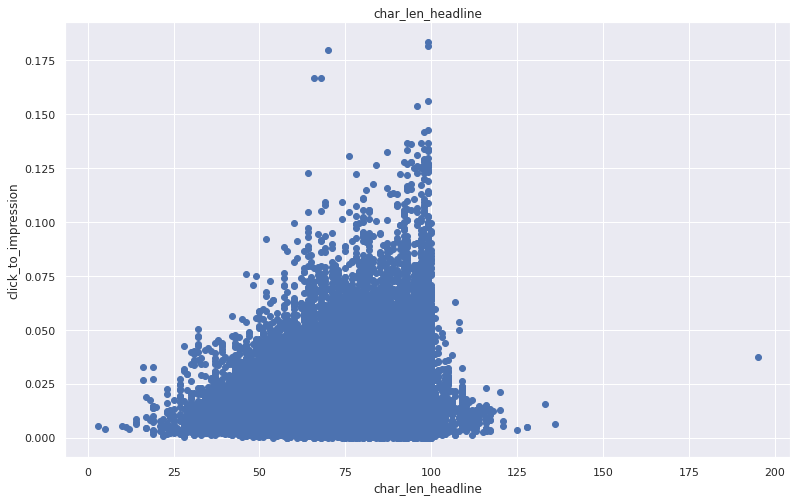

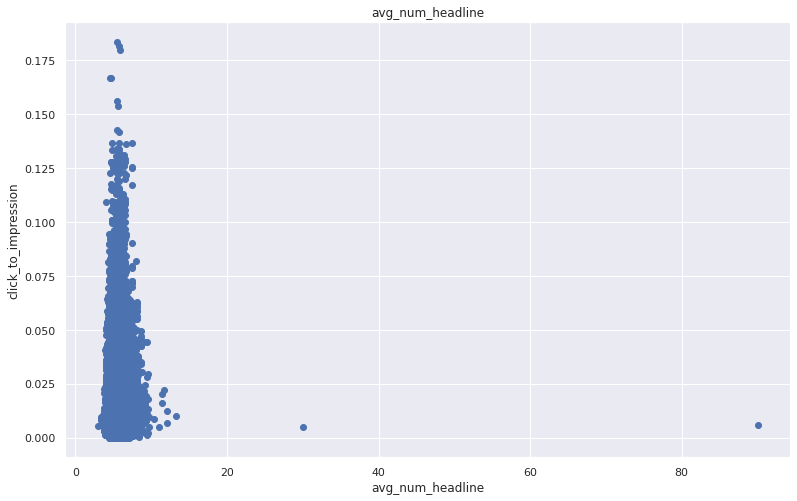

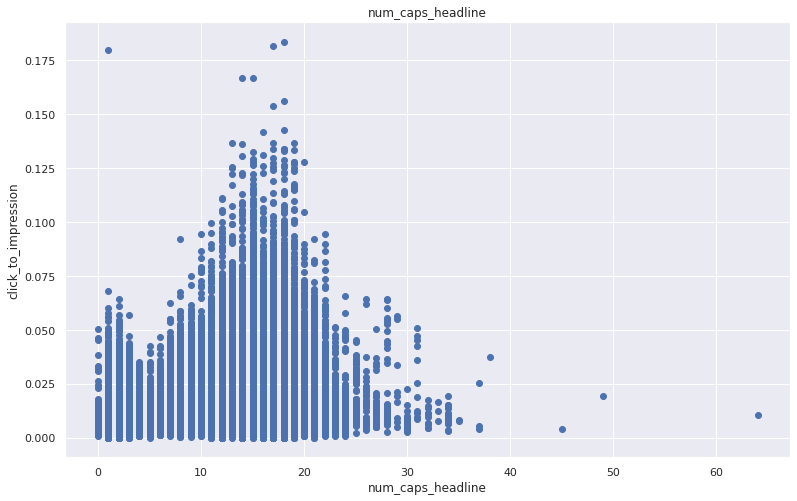

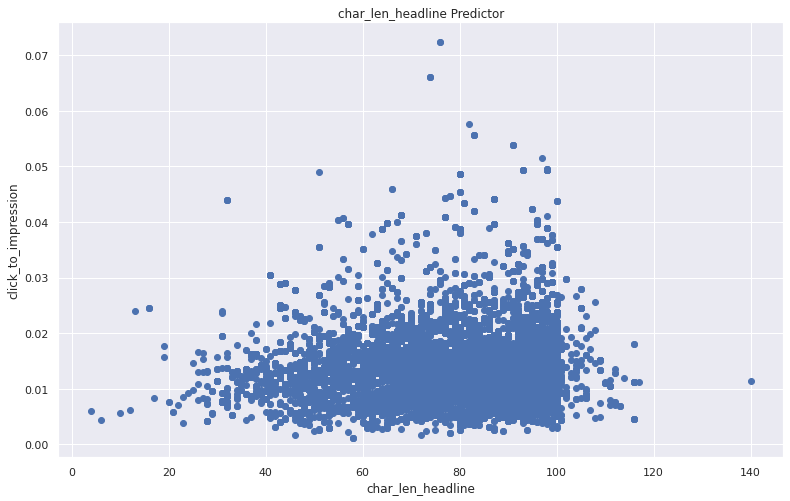

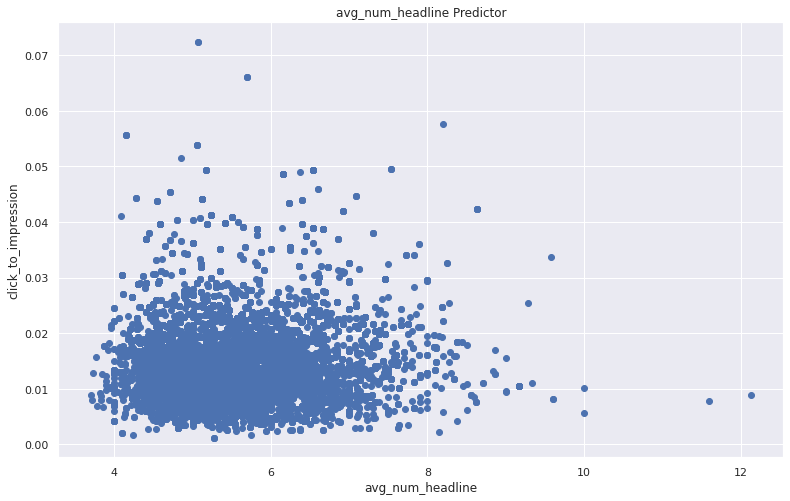

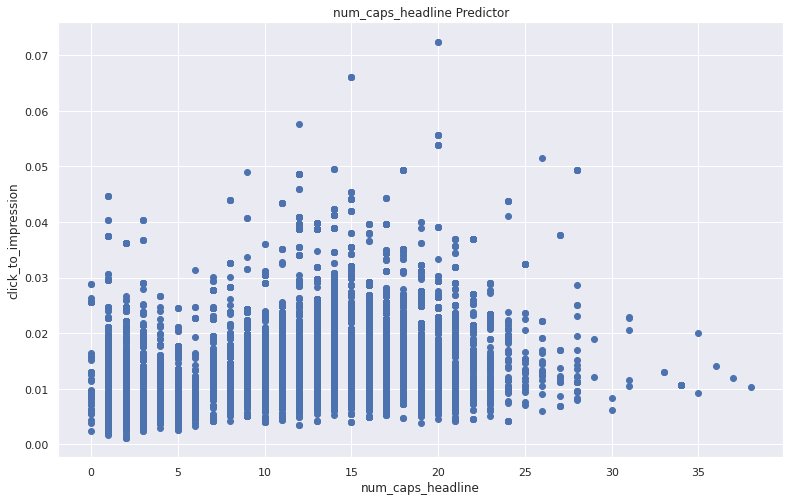

In [37]:
train, test = train_test_split(descriptors, test_size=0.3) 
y = train['new_column'].to_numpy()
train_split = train[['char_len_headline', 'char_len_text', 'word_num_headline',
       'word_num_text', 'avg_num_headline', 'avg_num_text',
       'num_caps_headline', 'num_caps_text', 'num_symbol_headline',
       'num_symbol_text', 'count_n1', 'count_n2', 'count_n1_text',
       'count_n2_text']]
x = train_split.to_numpy()

estimator = RandomForestRegressor()
selector = SelectFromModel(estimator)
ans1 = selector.fit(x,y)
status = ans1.get_support()
print(status)

x_feature_selected = train_split[['char_len_headline', 'avg_num_headline', 'num_caps_headline']]

for i, col in enumerate(x_feature_selected.columns):
       plt.figure()
       plt.title(col)
       plt.xlabel(col)
       plt.ylabel("click_to_impression")
       plt.scatter(x_feature_selected[col], y)

clf = RandomForestRegressor()
clf.fit(x_feature_selected, y)

test_obj = test['new_column'].to_numpy()
test_values = test[['char_len_headline', 'char_len_text', 'word_num_headline',
       'word_num_text', 'avg_num_headline', 'avg_num_text',
       'num_caps_headline', 'num_caps_text', 'num_symbol_headline',
       'num_symbol_text', 'count_n1', 'count_n2', 'count_n1_text',
       'count_n2_text']]

test_feature_selected = test[['char_len_headline', 'avg_num_headline', 'num_caps_headline']]

for i, col in enumerate(test_feature_selected.columns):
       plt.figure()
       plt.title(col + " Predictor")
       plt.xlabel(col)
       plt.ylabel("click_to_impression")
       plt.scatter(test_feature_selected[col], clf.predict(test_feature_selected))
       print( (float) ((clf.predict(test_feature_selected) == test_obj).sum() / len(test_obj)))

In [38]:
features = np.array(descriptors_split.columns.values)
print(features)
print(features[status])
ans1.transform(x)

['char_len_headline' 'char_len_text' 'word_num_headline' 'word_num_text'
 'avg_num_headline' 'avg_num_text' 'num_caps_headline' 'num_caps_text'
 'num_symbol_headline' 'num_symbol_text' 'count_n1' 'count_n2'
 'count_n1_text' 'count_n2_text']
['char_len_headline' 'avg_num_headline' 'num_caps_headline']


array([[ 69.        ,   5.75      ,  12.        ],
       [ 99.        ,   4.95      ,  20.        ],
       [ 72.        ,   5.53846154,  12.        ],
       [ 76.        ,   5.84615385,  13.        ],
       [ 82.        ,   4.82352941,  17.        ],
       [ 62.        ,   5.63636364,   1.        ],
       [ 75.        ,   4.6875    ,  18.        ],
       [100.        ,   5.        ,  19.        ],
       [ 74.        ,   5.28571429,  14.        ],
       [ 98.        ,   5.44444444,   2.        ],
       [ 70.        ,   5.        ,   2.        ],
       [ 97.        ,   5.38888889,  18.        ],
       [ 93.        ,   5.16666667,  17.        ],
       [ 75.        ,   5.35714286,  14.        ],
       [ 99.        ,   5.5       ,  18.        ],
       [ 85.        ,   5.        ,  17.        ],
       [ 97.        ,   6.0625    ,  16.        ],
       [ 53.        ,   5.88888889,   9.        ],
       [ 55.        ,   5.        ,  11.        ],
       [ 82.        ,   4.82352

0.0006409406356362993
0.0006409406356362993
0.0006409406356362993


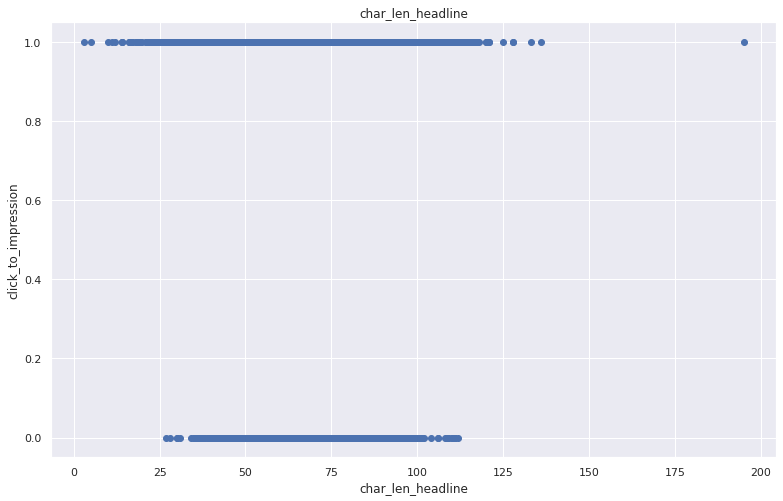

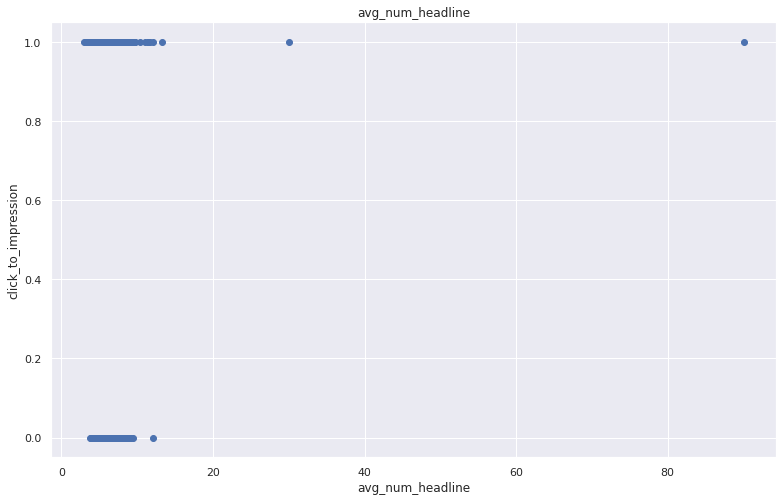

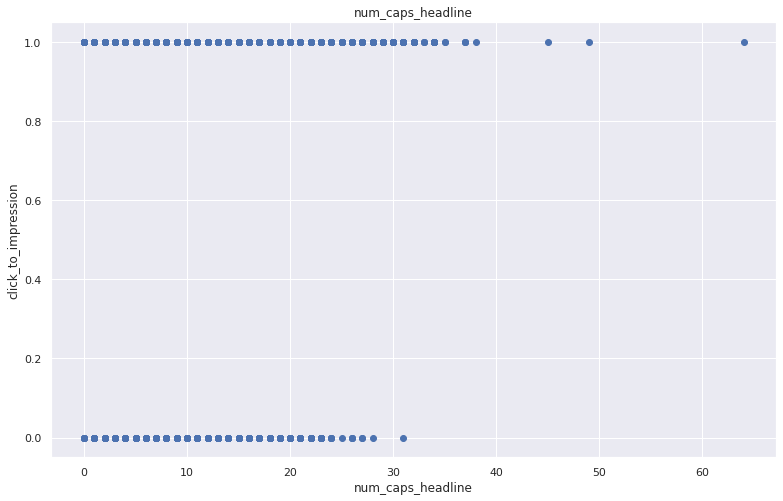

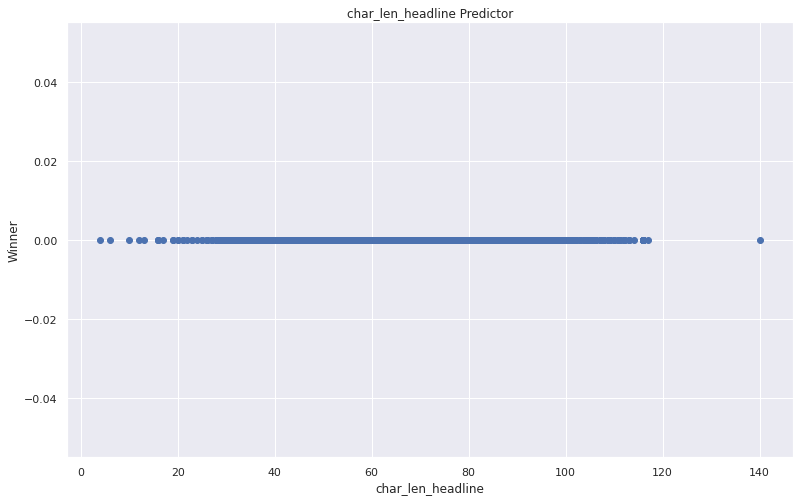

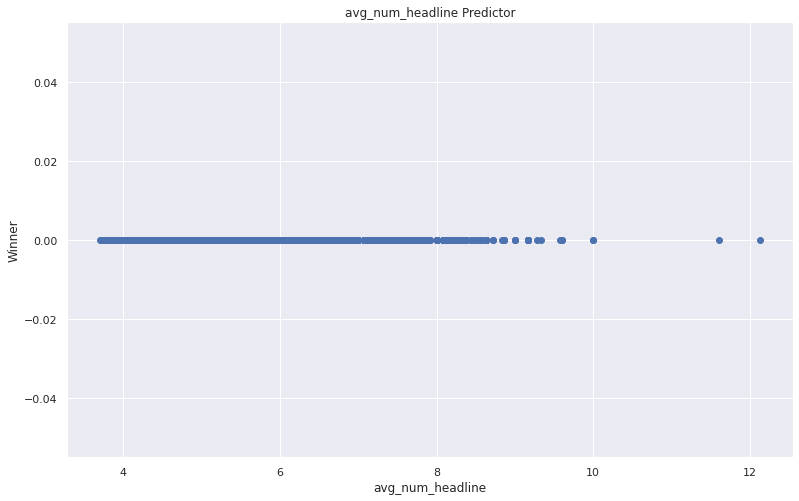

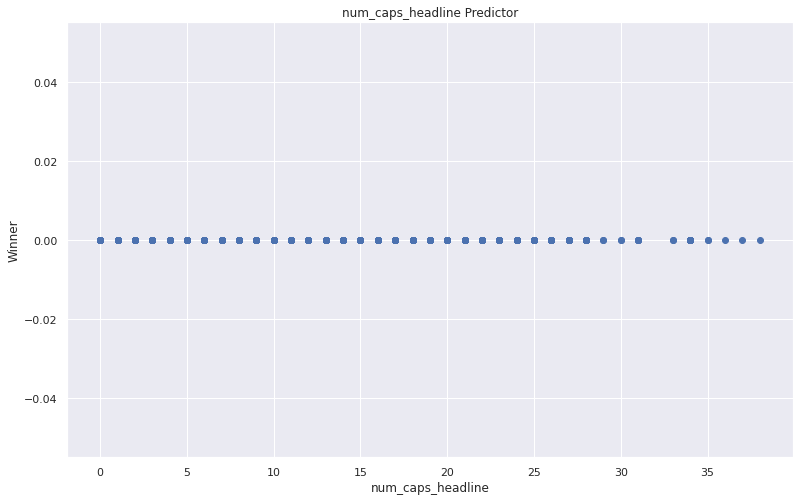

In [44]:
y = train['winner'].to_numpy()
y_converted = np.where(y == True, 0, 1)
train_split = train[['char_len_headline', 'char_len_text', 'word_num_headline',
       'word_num_text', 'avg_num_headline', 'avg_num_text',
       'num_caps_headline', 'num_caps_text', 'num_symbol_headline',
       'num_symbol_text', 'count_n1', 'count_n2', 'count_n1_text',
       'count_n2_text']]
x = train_split.to_numpy()

x_feature_selected = train_split[['char_len_headline', 'avg_num_headline', 'num_caps_headline']]

for i, col in enumerate(x_feature_selected.columns):
       plt.figure()
       plt.title(col)
       plt.xlabel(col)
       plt.ylabel("Winner")
       plt.scatter(x_feature_selected[col], y_converted)

clf = svm.SVC(kernel = 'rbf', C = 1)
clf.fit(x_feature_selected, y)

test_obj = test['new_column'].to_numpy()
test_values = test[['char_len_headline', 'char_len_text', 'word_num_headline',
       'word_num_text', 'avg_num_headline', 'avg_num_text',
       'num_caps_headline', 'num_caps_text', 'num_symbol_headline',
       'num_symbol_text', 'count_n1', 'count_n2', 'count_n1_text',
       'count_n2_text']]

test_feature_selected = test[['char_len_headline', 'avg_num_headline', 'num_caps_headline']]

for i, col in enumerate(test_feature_selected.columns):
       plt.figure()
       plt.title(col + " Predictor")
       plt.xlabel(col)
       plt.ylabel("Winner")
       plt.scatter(test_feature_selected[col], clf.predict(test_feature_selected))
       print( (float) ((clf.predict(test_feature_selected) == test_obj).sum() / len(test_obj)))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9aca6732-b264-45ec-8939-f227ca7a2274' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>